# Notebook pour le tracé des cartes d'indicateurs MAI (RASTERS, anomalies d'humidité du sol)

### Initialisation contexte test appli

In [1]:
import os

WRK_DIR = os.path.normpath('D:/MATHIS/0_Projet_Secheresse/1_Scripts/toolbox/eo4dm-oeil/EO4DM')
os.chdir(WRK_DIR)
WRK_DIR= os.path.join(WRK_DIR,'../DMPIPELINE_WORKST')

TERRITORY = 'New Caledonia (Fr)'
PRODUCT = 'MAI'
AREA = 'POUEMBOUT'
areas_key = 'nom'
DATE = '201708'

TERRITORY_str = TERRITORY.replace(' ', '_').replace('(', '').replace(')', '')
DATA_HISTO = os.path.join(WRK_DIR,'DATA_HISTO_backup',TERRITORY_str)
ANNEX_DIR = os.path.join(WRK_DIR,'ANNEX',TERRITORY_str)
INDIR_RASTERS = os.path.join(DATA_HISTO,'1_INDICATEURS/ALERT/MAI_GEE_SMAP/MONTH')
INDIR_ANNEX = os.path.join(ANNEX_DIR,'Areas')

In [2]:
import glob
import numpy as np
import geopandas as gpd
import rasterio
import rasterio.mask
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar


### Prépare le dossier de sortie

In [3]:
# --- Generate directories/sub-directories ---
OUTDIR_MAPS = os.path.join(WRK_DIR, f'PLOT_MAP_DROUGHT_{TERRITORY_str}')
os.umask(0) # used to reset the directories permission
if not os.path.exists(OUTDIR_MAPS):
    os.makedirs(OUTDIR_MAPS)
    os.chmod(OUTDIR_MAPS, 0o777)

### Lecture et préparation des données

In [4]:
raster_in = glob.glob(os.path.join(INDIR_RASTERS, f'*{PRODUCT}*{DATE}*.tif'))[0]
contours_in = glob.glob(os.path.join(INDIR_ANNEX, '*.shp'))[0]
gdf_contours = gpd.read_file(contours_in)
gdf_area = gdf_contours[gdf_contours[areas_key] == AREA]

### Définition des colormaps

In [5]:
colors_drought = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # Rouge, blanc, bleu
ticks_drought = [-3, 0, 3]
n_bins = 100  # Nombre de bins pour la colormap
cmap_name = "custom_cmap"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors_drought, N=n_bins)

color_nodata = '#DCDCDC' # lightgray
# color_nodata = '#add8e6' # lightblue

### Affichage et export de la carte

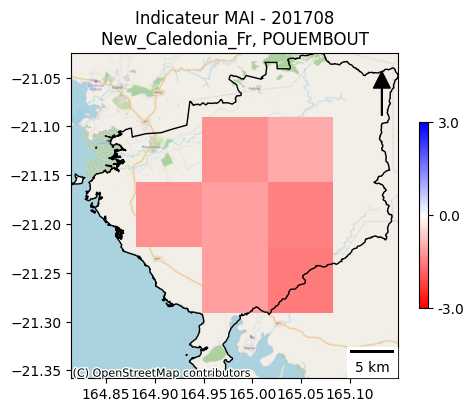

In [6]:
with rasterio.open(raster_in) as src:
    src_crs = src.crs
    gdf_area = gdf_area.to_crs(src_crs)
    raster_data, raster_transform = rasterio.mask.mask(src, gdf_area.geometry, crop=True, invert=False, nodata=np.nan)
    raster_data = raster_data[0]
    bounds = gdf_area.geometry.bounds

fig, ax = plt.subplots(figsize=(5, 5))

ax.set_facecolor(color_nodata)
gdf_area.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)

if TERRITORY=='Fiji' or TERRITORY=='Vanuatu':
    for geometry in gdf_contours['geometry']:
        if geometry.geom_type == 'Polygon':
            ax.add_patch(plt.Polygon(list(geometry.exterior.coords), facecolor=color_nodata, zorder=-1))
        elif geometry.geom_type == 'MultiPolygon':
            for poly in geometry.geoms:
                ax.add_patch(plt.Polygon(list(poly.exterior.coords), facecolor=color_nodata, zorder=-1))

im = ax.imshow(raster_data, cmap=custom_cmap, interpolation='nearest', vmin=ticks_drought[0], vmax=ticks_drought[-1], extent=(bounds.minx.values[0], bounds.maxx.values[0], bounds.miny.values[0], bounds.maxy.values[0]))
cbar  = plt.colorbar(im, ax=ax, ticks=ticks_drought, format="%1.1f", shrink=0.4)
ctx.add_basemap(ax, crs=src_crs, source=ctx.providers.OpenStreetMap.Mapnik, zorder=-1)

# Add Scale bar
distance_meters = 1
if src_crs=='EPSG:4326':
    points_x =[bounds.minx.values[0], bounds.minx.values[0]+1]
    points_y = [bounds.miny.values[0], bounds.miny.values[0]]
    points = gpd.GeoSeries.from_xy(points_x, points_y, crs='EPSG:4326')
    points = points.to_crs(3395)
    distance_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(distance_meters, location='lower right'))

# Add North arrow
arrow_properties = dict(facecolor='black', edgecolor='black', width=0.5, shrink=0.05)
ax.annotate('', xy=(0.95, 0.95), xytext=(0.95, 0.8),
            arrowprops=arrow_properties, ha='center', va='bottom',
            fontsize=12, color='black', xycoords='axes fraction')

plt.title(f'Indicateur {PRODUCT} - {DATE}\n{TERRITORY_str}, {AREA}')
plt.tight_layout()
plt.show()

# Save figure
fig.savefig(os.path.join(OUTDIR_MAPS, f'maps_{PRODUCT}_{TERRITORY_str}_{AREA}_{DATE}.png'), dpi=300)
